# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Linear multidimensional regression

## I a) - Loading the data

In [2]:
data = pd.read_csv('data/linear_multi.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
Y = Y.reshape((Y.shape[0], 1))

## I b) - Problem definition

We can define our MSE cost function $J(\theta)$ as follows:
$$
J(\mathbf{\theta}, \mathbf{X}, \mathbf{Y}) = \frac{1}{2n} \sum_{i=1}^n (Y_i - \mathbf{X_i} \mathbf{\theta})^2
= \frac{1}{2 n} \| \mathbf{Y} - \mathbf{X} \mathbf{\theta} \|_2^2,
$$
with $\mathbf{Y} = [y_1 \cdots y_n]$, $\mathbf{X} = [\mathbf{x_1} \cdots \mathbf{x_n}]$,

$\mathbf{Y} \in \mathbb{R}^{n\times{1}}$ being the vector of labels, $\mathbf{X} \in \mathbb{R}^{n\times{p}}$ being the vector of features, $\mathbf{\theta} \in \mathbb{R}^{p\times{1}}$ being our parameters, and $n$ the number of samples.

Now we can calculate the gradient $\nabla J(\mathbf{\theta})$:
$$
\nabla J(\mathbf{\theta}, \mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \sum_{i=1}^n \mathbf{X_i}(Y_i - \mathbf{X_i} \mathbf{\theta})
= - \frac{1}{n} \mathbf{X^\top}(\mathbf{Y} - \mathbf{X} \mathbf{\theta}),
$$

It leads us to the gradient descend (GD) iterative algorithm:
$$
\mathbf{\theta}^{t+1} := \mathbf{\theta}^{t} - \eta_t \nabla J(\mathbf{\theta}, \mathbf{X}, \mathbf{Y})
$$

It is common to decay the learning rate linearly until iteration $\tau$:
$$
\eta_t = (1-\alpha)\eta_0 + \alpha \eta_\tau
$$
with $\alpha = \frac{t}{\tau}$, and usually here we are going to take $\tau \approx 200$ and $\eta_\tau = \frac{\eta_0}{100}$

And finally, our linear prediction $\mathbf{\hat{Y}}$ can be expressed as:
$$
\mathbf{\hat{Y}} = \mathbf{X}\mathbf{\theta}
$$
- **You are asked, wherever there are TODO expressions, to change the default expression by the right one**
- **Most expressions you are asked to implement can be found in the introduction above**

In [3]:
class LinearRegressor():
    def __init__(self, X, Y, penalization=None):
        p = X.shape[1]
        self.theta = np.random.normal(0, 1, p).reshape((p, 1))
        self.grad_theta = None
        self.training_losses_history = []
        self.validation_losses_history = []
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.penalization = penalization
        self.gamma = None
        
    def split_train_validation(self, X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
        
    def predict(self, X):
        return X.dot(self.theta)
    
    def compute_grad(self, X, Y, loss='MSE'):
        """Least-squares gradient"""
        assert(X.shape[0] == Y.shape[0])
        n = X.shape[0]
        if loss == 'MSE':
            grad = - (1 / n) * X.T.dot(Y - self.predict(X))
            if self.penalization == 'l2':
                grad += 2 * self.gamma * self.theta
            if self.penalization == 'l1':
                grad += self.gamma * np.sign(self.theta)
        else:
            raise NotImplementedError
        return grad
    
    def step_gradient_descent(self, step, X, Y):
        self.grad_theta = self.compute_grad(X, Y, loss='MSE')
        self.theta -= step * self.grad_theta
        
    def loss(self, Y_true, Y_pred, loss='MSE'):
        """Least-squares loss"""
        assert(Y_true.shape[0] == Y_pred.shape[0])
        n = Y_pred.shape[0]
        if loss == 'MSE':
            loss = (1 / (2 * n)) * np.linalg.norm(Y_true - Y_pred, ord=2) ** 2
            if self.penalization == 'l2':
                loss += self.gamma * np.linalg.norm(self.theta, ord=2) ** 2
            elif self.penalization == 'l1':
                loss += self.gamma * np.linalg.norm(self.theta, ord=1)
        else:
            raise NotImplementedError
        return loss
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
    
    ## Goodfellow, p295
    def apply_step_decay(self, initial_step, k, tau=250):
        alpha = min(k / tau, 1)
        step_tau = initial_step / 100
        return (1 - alpha) * initial_step + alpha * step_tau
        
    def fit(self, initial_step=1e-1, min_iterations=50, max_iterations=5000, gamma=1e-3, 
            early_stopping=True, early_stopping_delta=1e-3, early_stopping_lookbehind=50, 
            step_decay=True, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        step = initial_step
        self.gamma = gamma
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.step_gradient_descent(step, self.X_tr, self.Y_tr)
            if step_decay:
                step = self.apply_step_decay(initial_step, iteration_number)
            training_loss = self.loss(self.Y_tr, self.predict(self.X_tr))
            self.training_losses_history.append(training_loss)
            validation_loss = self.loss(self.Y_val, self.predict(self.X_val))
            self.validation_losses_history.append(validation_loss)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t validation loss: {2:.4f}"
                print(msg.format(iteration_number, training_loss, validation_loss))
            if cpt_patience >= early_stopping_lookbehind:
                break

    def plot_loss_history(self):
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)), 
                 self.validation_losses_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("MSE loss", fontsize=15)
        if not self.penalization:
            title = "MSE loss evolution during training, no penalization"
        else:
            title = "MSE loss evolution during training, penalization {}"
            title = title.format(self.penalization)
        plt.title(title, fontsize=20)
        plt.show()
    
    def plot_parameters(self, title=None):
        plt.figure(figsize=(6, 4))
        plt.scatter(range(len(self.theta)), self.theta)
        plt.xlabel("parameter dimension", fontsize=15)
        plt.ylabel("value", fontsize=15)
        if title is None:
            if not self.penalization:
                plt.title("Scatter plot of the learned parameters, no penalization", fontsize=15)
            else:
                plt.title(
                    "Scatter plot of the learned parameters, penalization {}".format(self.penalization), fontsize=15
                )
        else:
                plt.title(title)
        plt.show()

In [4]:
linear_regressor = LinearRegressor(X, Y)
ridge_linear_regressor = LinearRegressor(X, Y, penalization='l2')
lasso_linear_regressor = LinearRegressor(X, Y, penalization='l1')

linear_regressor.fit(verbose=True)
ridge_linear_regressor.fit(gamma=1e-3, verbose=True, step_decay=True)
lasso_linear_regressor.fit(gamma=1e-3, verbose=True, step_decay=True)

iteration number: 1	 training loss: 8874.9176	 validation loss: 8523.7543
iteration number: 2	 training loss: 7100.8755	 validation loss: 6871.8839
iteration number: 3	 training loss: 5697.7113	 validation loss: 5555.7248
iteration number: 4	 training loss: 4585.5667	 validation loss: 4504.8413
iteration number: 5	 training loss: 3702.2433	 validation loss: 3664.0197
iteration number: 6	 training loss: 2999.2021	 validation loss: 2989.8878
iteration number: 7	 training loss: 2438.4892	 validation loss: 2448.3045
iteration number: 8	 training loss: 1990.3692	 validation loss: 2012.3391
iteration number: 9	 training loss: 1631.4991	 validation loss: 1660.7050
iteration number: 10	 training loss: 1343.5185	 validation loss: 1376.5419
iteration number: 11	 training loss: 1111.9573	 validation loss: 1146.4682
iteration number: 12	 training loss: 925.3889	 validation loss: 959.8421
iteration number: 13	 training loss: 774.7726	 validation loss: 808.1833
iteration number: 14	 training loss: 6

iteration number: 83	 training loss: 109.1228	 validation loss: 113.7034
iteration number: 84	 training loss: 109.1219	 validation loss: 113.7025
iteration number: 85	 training loss: 109.1211	 validation loss: 113.7017
iteration number: 86	 training loss: 109.1203	 validation loss: 113.7011
iteration number: 87	 training loss: 109.1197	 validation loss: 113.7006
iteration number: 88	 training loss: 109.1191	 validation loss: 113.7002
iteration number: 89	 training loss: 109.1187	 validation loss: 113.6999
iteration number: 90	 training loss: 109.1182	 validation loss: 113.6997
iteration number: 91	 training loss: 109.1178	 validation loss: 113.6996
iteration number: 92	 training loss: 109.1175	 validation loss: 113.6995
iteration number: 93	 training loss: 109.1172	 validation loss: 113.6994
iteration number: 94	 training loss: 109.1169	 validation loss: 113.6994
iteration number: 95	 training loss: 109.1167	 validation loss: 113.6995
iteration number: 96	 training loss: 109.1165	 vali

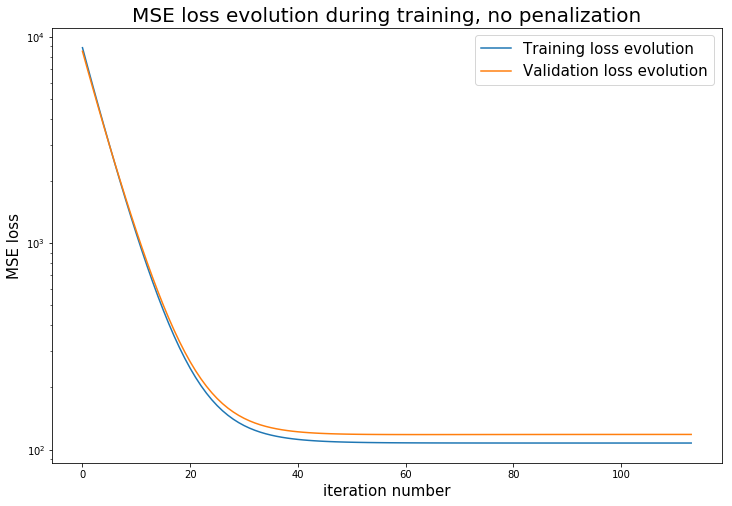

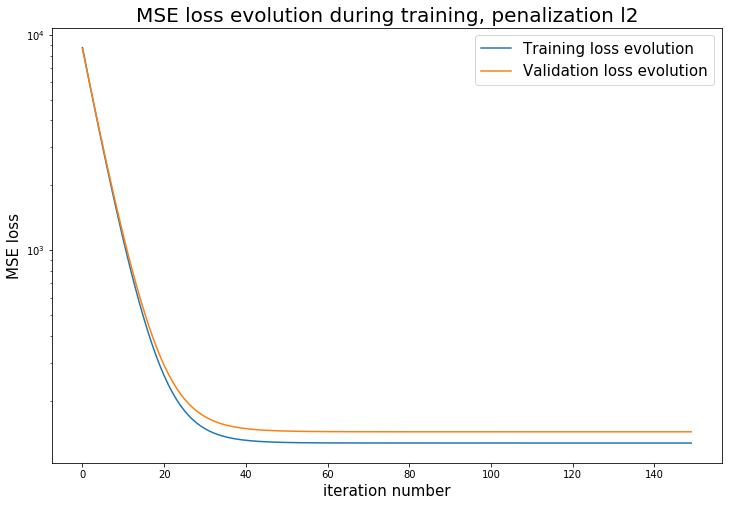

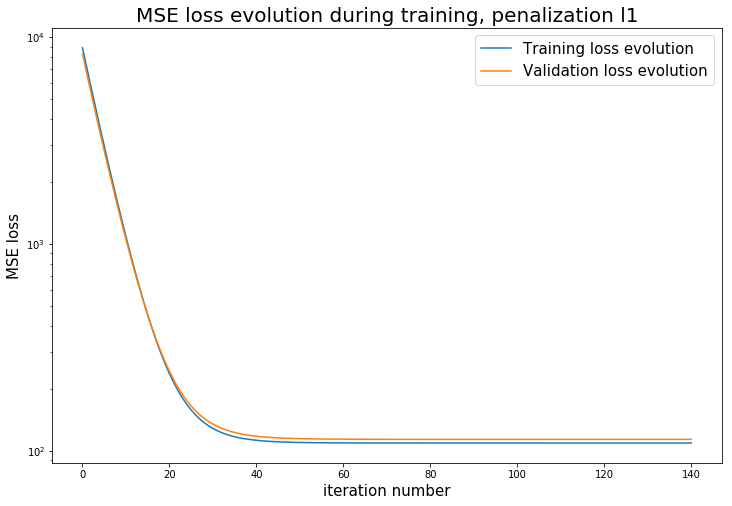

In [5]:
linear_regressor.plot_loss_history()
ridge_linear_regressor.plot_loss_history()
lasso_linear_regressor.plot_loss_history()

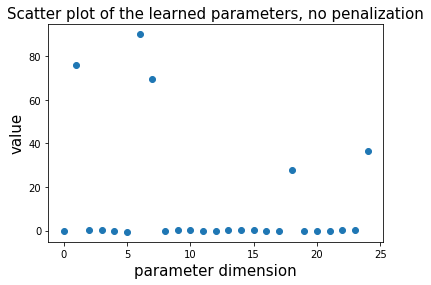

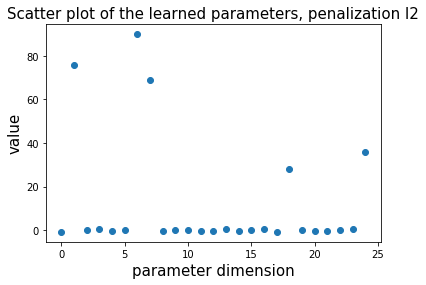

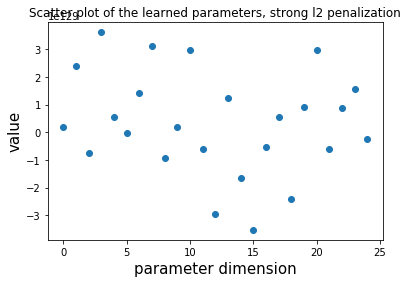

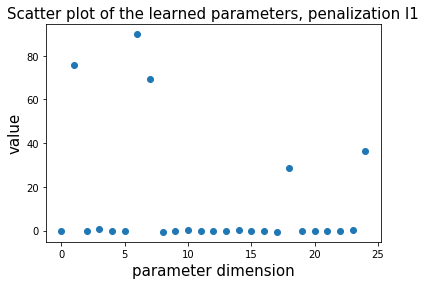

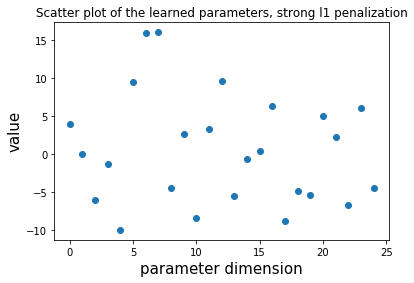

In [6]:
#linear
linear_regressor.plot_parameters()

# ridge
    # normal ridge
ridge_linear_regressor.plot_parameters()
    # strong l2 regularization
ridge_linear_regressor = LinearRegressor(X, Y, penalization='l2')
ridge_linear_regressor.fit(gamma=1e2, verbose=False, step_decay=False)
title = "Scatter plot of the learned parameters, strong l2 penalization"
ridge_linear_regressor.plot_parameters(title)

# lasso
    # normal lasso
lasso_linear_regressor.plot_parameters()
    # strong l1 regularization
lasso_linear_regressor = LinearRegressor(X, Y, penalization='l1')
lasso_linear_regressor.fit(gamma=1e2, verbose=False, step_decay=False)
title = "Scatter plot of the learned parameters, strong l1 penalization"
lasso_linear_regressor.plot_parameters(title)

## Questions:
#### - Did you succeed to have a low validation loss?
#### - What are l1 and l2 penalization strategies useful for? Did you achieve to improve your model's performance with them? Try different penalization values.
<span style="color:green">
Both strategies prevent weights from reaching extreme values to control complexity of the model and prevent overfitting.<br/>
L1 penalization may lead to sparse weights, thus can it be used as a model memory reduction strategy.<br/>
L2 shrinks all weights closer to zero, not exatly zero, and is more suited to algorithms that require perfect differentiability and smoothness
</span>
#### - Consider the parameters plot. What could you conclude about the features information?
<span style="color:green">
In case right-fitting with normal l1 and l2 penalizations most weights end-up very close to zeros. That is because the features associated to those weights are not statistically relevant for the prediction. We can conclude there are $5$ features that are informative to the prediction.
</span>  

# II - Non linear unidimensional regression

## II a) - Loading the data

In [19]:
data = pd.read_csv('data/non_linear.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
X, Y = X.reshape((Y.shape[0], 1)), Y.reshape((Y.shape[0], 1))

## II b) - Visualizing the data

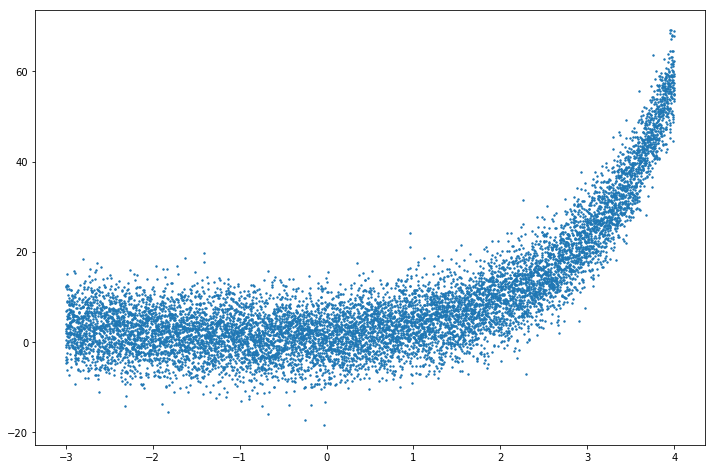

In [20]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, s=2)
plt.show()

- Notice that relation between $X$ and $Y$ is non linear
- You are supposed to map X to a new non linear representation more suited to the type of dependance between $X$ and $y$
- Using this new representation of $X$ use the linear regressor properties from the beginning to perform predictions

In [21]:
class PolynomialRegressor(LinearRegressor):
    def __init__(self, X, Y, degree=2, penalization=None):
        self.degree = degree
        self.initial_X_tr, self.initial_X_val, _, _ = self.split_train_validation(X, Y)
        X_transformed = self.non_linear_mapping(X)
        super(PolynomialRegressor, self).__init__(X_transformed, Y, penalization)
        
    def split_train_validation(self, X, Y, test_size=0.25, seed=True):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
        
    def non_linear_mapping(self, X):
        return np.hstack([X**i for i in range(self.degree+1)])
    
    def predict(self, X, apply_features_transformation=False):
        if apply_features_transformation:
            X_transformed = self.non_linear_mapping(X)
            return super(PolynomialRegressor, self).predict(X_transformed)
        else:
            return super(PolynomialRegressor, self).predict(X)
        
    def plot_prediction(self):
        assert self.initial_X_val.shape[1] == 1, "Too high dimensional design matrix to be plotted!"
        plt.figure(figsize=(12, 8))
        plt.scatter(self.initial_X_val, self.Y_val, s=5)
        plt.scatter(
            self.initial_X_val, self.predict(self.initial_X_val, apply_features_transformation=True), 
            color='red', s=5
        )
        plt.title("Prediction with polynomial regressor, degree={}".format(self.degree), fontsize=15)
        plt.show()

In [22]:
polynomial_regressor = PolynomialRegressor(X, Y, degree=2)
polynomial_regressor.fit(initial_step=1e-2, max_iterations=500, verbose=True)

iteration number: 1	 training loss: 98.3694	 validation loss: 103.7023
iteration number: 2	 training loss: 56.9265	 validation loss: 59.6730
iteration number: 3	 training loss: 40.4052	 validation loss: 41.6839
iteration number: 4	 training loss: 33.5493	 validation loss: 33.9726
iteration number: 5	 training loss: 30.4759	 validation loss: 30.3927
iteration number: 6	 training loss: 28.9043	 validation loss: 28.5193
iteration number: 7	 training loss: 27.9453	 validation loss: 27.3812
iteration number: 8	 training loss: 27.2497	 validation loss: 26.5811
iteration number: 9	 training loss: 26.6787	 validation loss: 25.9514
iteration number: 10	 training loss: 26.1762	 validation loss: 25.4184
iteration number: 11	 training loss: 25.7186	 validation loss: 24.9478
iteration number: 12	 training loss: 25.2954	 validation loss: 24.5223
iteration number: 13	 training loss: 24.9013	 validation loss: 24.1325
iteration number: 14	 training loss: 24.5330	 validation loss: 23.7726
iteration numb

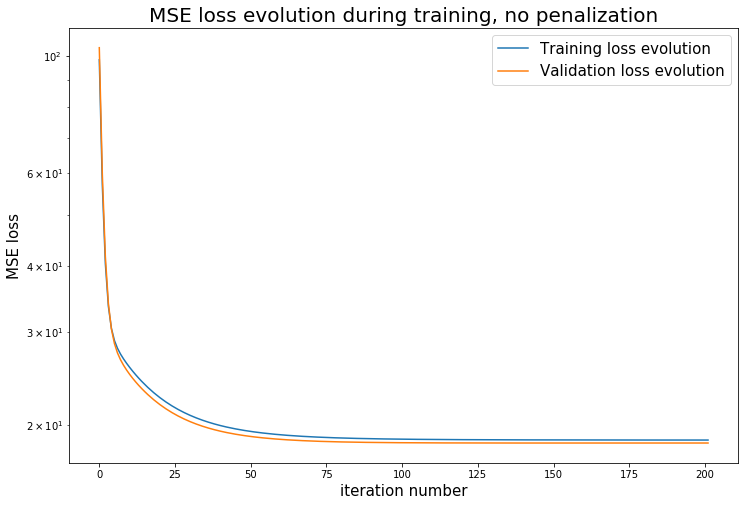

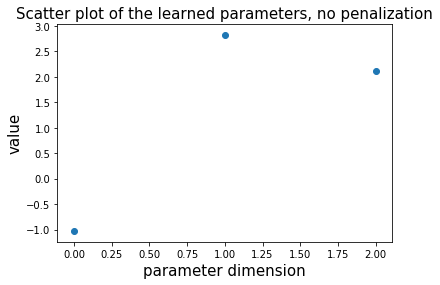

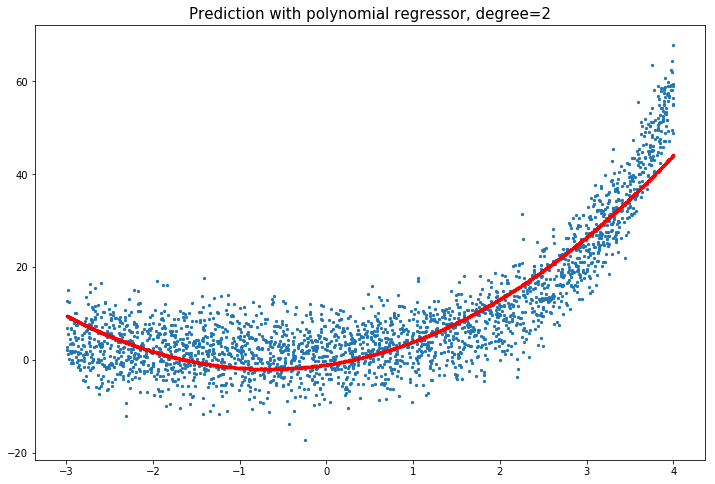

In [23]:
polynomial_regressor.plot_loss_history()
polynomial_regressor.plot_parameters()
polynomial_regressor.plot_prediction()

iteration number: 1	 training loss: 19.4525	 validation loss: 19.8703
iteration number: 2	 training loss: 19.2237	 validation loss: 19.6008
iteration number: 3	 training loss: 19.0164	 validation loss: 19.3553
iteration number: 4	 training loss: 18.8286	 validation loss: 19.1314
iteration number: 5	 training loss: 18.6583	 validation loss: 18.9271
iteration number: 6	 training loss: 18.5039	 validation loss: 18.7406
iteration number: 7	 training loss: 18.3637	 validation loss: 18.5702
iteration number: 8	 training loss: 18.2363	 validation loss: 18.4144
iteration number: 9	 training loss: 18.1206	 validation loss: 18.2718
iteration number: 10	 training loss: 18.0154	 validation loss: 18.1413
iteration number: 11	 training loss: 17.9197	 validation loss: 18.0216
iteration number: 12	 training loss: 17.8326	 validation loss: 17.9118
iteration number: 13	 training loss: 17.7533	 validation loss: 17.8111
iteration number: 14	 training loss: 17.6809	 validation loss: 17.7185
iteration numbe

iteration number: 267	 training loss: 16.6418	 validation loss: 16.3214
iteration number: 268	 training loss: 16.6418	 validation loss: 16.3213
iteration number: 269	 training loss: 16.6418	 validation loss: 16.3213
iteration number: 270	 training loss: 16.6417	 validation loss: 16.3213
iteration number: 271	 training loss: 16.6417	 validation loss: 16.3213
iteration number: 272	 training loss: 16.6417	 validation loss: 16.3213
iteration number: 273	 training loss: 16.6417	 validation loss: 16.3212
iteration number: 274	 training loss: 16.6416	 validation loss: 16.3212
iteration number: 275	 training loss: 16.6416	 validation loss: 16.3212
iteration number: 276	 training loss: 16.6416	 validation loss: 16.3212
iteration number: 277	 training loss: 16.6416	 validation loss: 16.3212
iteration number: 278	 training loss: 16.6415	 validation loss: 16.3211
iteration number: 279	 training loss: 16.6415	 validation loss: 16.3211
iteration number: 280	 training loss: 16.6415	 validation loss: 

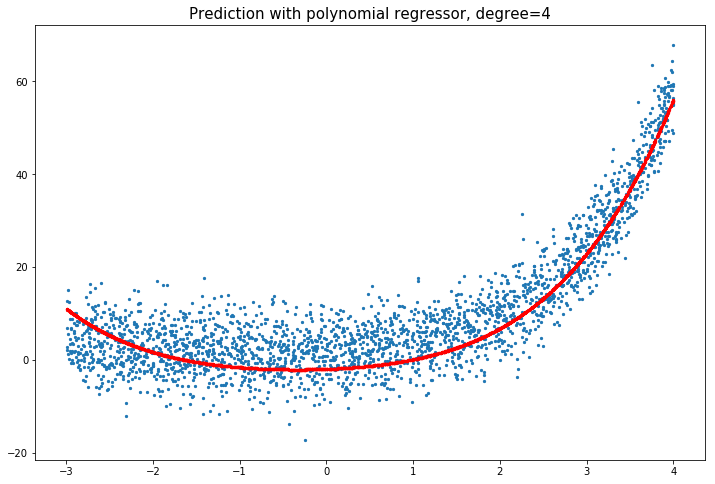

In [32]:
polynomial_regressor = PolynomialRegressor(X, Y, degree=4)
polynomial_regressor.fit(initial_step=1e-5, max_iterations=500, verbose=True)
polynomial_regressor.plot_prediction()

## Questions:
#### - Did you succeed to fit the data using a non-linear mapping transformation?
#### - Try different degrees, which one leads you to the best validation error?
<span style="color:green">
No right answer here, we only want to compare your strategies to tackle the problem, but you can get satisfying results using degree=4.
</span>  

# III - Logistic regression

## III a) - Loading the data

In [35]:
data = pd.read_csv('data/breast_cancer_classification.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
Y = Y.reshape((Y.shape[0], 1))

## III b) - Problem definition

Using the sigmoid function $\sigma(x)$ defined as:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

We can define our binary cross-entropy cost function $J(\theta)$ as follows:
$$
J(\mathbf{\theta}, \mathbf{X}, \mathbf{Y}) = -\frac{1}{n} \sum_{i=1}^n Y_i \log \sigma(\mathbf{X_i}\mathbf{\theta}) + (1 - Y_i) \log (1 - \sigma(\mathbf{X_i} \mathbf{\theta})),
$$
with $\mathbf{Y} = [y_1 \cdots y_n]$, $\mathbf{X} = [\mathbf{x_1} \cdots \mathbf{x_n}]$,

$\mathbf{Y} \in \mathbb{R}^{n\times{1}}$ being the vector of labels, $\mathbf{X} \in \mathbb{R}^{n\times{p}}$ being the vector of features, $\mathbf{\theta} \in \mathbb{R}^{p\times{1}}$ being our parameters, and $n$ the number of samples.

Now we can calculate the gradient $\nabla J(\mathbf{\theta})$:
$$
\nabla J(\mathbf{\theta}, \mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \sum_{i=1}^n \mathbf{X_i}(Y_i - \sigma(\mathbf{X_i}\mathbf{\theta})),
$$

It leads us to the gradient descend (GD) iterative algorithm:
$$
\mathbf{\theta}^{t+1} := \mathbf{\theta}^{t} - \eta_t \nabla J(\mathbf{\theta}, \mathbf{X}, \mathbf{Y})
$$

And finally, our linear prediction $\mathbf{\hat{Y}}$ can be expressed as:
$$
\mathbf{\hat{Y}} = \sigma(\mathbf{X}\mathbf{\theta})
$$

In [14]:
class LogisticRegressor(LinearRegressor):
    def __init__(self, X, Y, penalization=None):
        super(LogisticRegressor, self).__init__(X, Y, penalization)
        self.X_tr, self.X_val = self.normalize(self.X_tr), self.normalize(self.X_val)
        
    def normalize(self, X):
        X -= np.mean(X, axis=0)
        try:
            X /= np.std(X, axis=0)
        except ZeroDivisionError as e:
            warnings.warn("At least one column passed has 0 std thus cannot be scaled to 1 std")
            X /= np.std(X, axis=0) + EPSILON
        return X
    
    def accuracy_on_validation(self):
        y_pred = self.predict(self.X_val)
        y_pred = np.hstack([1-y_pred, y_pred]) # to format to a [0, 1] probabilities matrix
        return (np.argmax(y_pred, axis=1) == np.squeeze(self.Y_val)).mean()
        
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    def predict(self, X, apply_normalization=False):
        if apply_normalization:
            X = self.normalize(X)
        return self.sigmoid(X.dot(self.theta))

    def compute_grad(self, X, Y, loss='CE'):
        """Binary cross-entropy gradient"""
        assert(X.shape[0] == Y.shape[0])
        n = X.shape[0]
        if loss == 'CE':
            grad = -(1 / n) * X.T.dot(Y - self.predict(X))
            if self.penalization == 'l2':
                grad += 2 * self.gamma * self.theta
            if self.penalization == 'l1':
                grad += np.sign(self.gamma)
        else:
            raise NotImplementedError
        return grad

    def step_gradient_descent(self, step, X, Y):
        self.grad_theta = self.compute_grad(X, Y, loss='CE')
        self.theta -= step * self.grad_theta

    def loss(self, Y_true, Y_pred, loss='CE'):
        """Binary cross-entropy loss"""
        assert(Y_true.shape[0] == Y_pred.shape[0])
        n = Y_true.shape[0]
        if loss == 'CE':
            loss = -np.mean(Y_true*np.log(Y_pred+EPSILON) + (1-Y_true)*np.log(1-Y_pred+EPSILON))
            if self.penalization == 'l2':
                loss += self.gamma * np.linalg.norm(self.theta, ord=2) ** 2
            elif self.penalization == 'l1':
                loss += self.gamma * np.linalg.norm(self.theta, ord=1)
        else:
            raise NotImplementedError
        return loss

iteration number: 1	 training loss: 1.2623	 validation loss: 1.6617
iteration number: 2	 training loss: 1.1821	 validation loss: 1.5860
iteration number: 3	 training loss: 1.1085	 validation loss: 1.5188
iteration number: 4	 training loss: 1.0414	 validation loss: 1.4583
iteration number: 5	 training loss: 0.9804	 validation loss: 1.4031
iteration number: 6	 training loss: 0.9252	 validation loss: 1.3523
iteration number: 7	 training loss: 0.8753	 validation loss: 1.3053
iteration number: 8	 training loss: 0.8300	 validation loss: 1.2614
iteration number: 9	 training loss: 0.7888	 validation loss: 1.2202
iteration number: 10	 training loss: 0.7512	 validation loss: 1.1814
iteration number: 11	 training loss: 0.7168	 validation loss: 1.1446
iteration number: 12	 training loss: 0.6855	 validation loss: 1.1099
iteration number: 13	 training loss: 0.6568	 validation loss: 1.0769
iteration number: 14	 training loss: 0.6306	 validation loss: 1.0457
iteration number: 15	 training loss: 0.6066

iteration number: 272	 training loss: 0.1009	 validation loss: 0.1705
iteration number: 273	 training loss: 0.1008	 validation loss: 0.1703
iteration number: 274	 training loss: 0.1006	 validation loss: 0.1701
iteration number: 275	 training loss: 0.1005	 validation loss: 0.1699
iteration number: 276	 training loss: 0.1004	 validation loss: 0.1698
iteration number: 277	 training loss: 0.1002	 validation loss: 0.1696
iteration number: 278	 training loss: 0.1001	 validation loss: 0.1694
iteration number: 279	 training loss: 0.1000	 validation loss: 0.1692
iteration number: 280	 training loss: 0.0999	 validation loss: 0.1691
iteration number: 281	 training loss: 0.0997	 validation loss: 0.1689
iteration number: 282	 training loss: 0.0996	 validation loss: 0.1687
iteration number: 283	 training loss: 0.0995	 validation loss: 0.1686
iteration number: 284	 training loss: 0.0993	 validation loss: 0.1684
iteration number: 285	 training loss: 0.0992	 validation loss: 0.1682
iteration number: 28

iteration number: 426	 training loss: 0.0857	 validation loss: 0.1536
iteration number: 427	 training loss: 0.0856	 validation loss: 0.1536
iteration number: 428	 training loss: 0.0856	 validation loss: 0.1535
iteration number: 429	 training loss: 0.0855	 validation loss: 0.1534
iteration number: 430	 training loss: 0.0854	 validation loss: 0.1534
iteration number: 431	 training loss: 0.0853	 validation loss: 0.1533
iteration number: 432	 training loss: 0.0853	 validation loss: 0.1532
iteration number: 433	 training loss: 0.0852	 validation loss: 0.1532
iteration number: 434	 training loss: 0.0851	 validation loss: 0.1531
iteration number: 435	 training loss: 0.0851	 validation loss: 0.1530
iteration number: 436	 training loss: 0.0850	 validation loss: 0.1530
iteration number: 437	 training loss: 0.0849	 validation loss: 0.1529
iteration number: 438	 training loss: 0.0848	 validation loss: 0.1529
iteration number: 439	 training loss: 0.0848	 validation loss: 0.1528
iteration number: 44

iteration number: 706	 training loss: 0.0700	 validation loss: 0.1427
iteration number: 707	 training loss: 0.0700	 validation loss: 0.1427
iteration number: 708	 training loss: 0.0700	 validation loss: 0.1427
iteration number: 709	 training loss: 0.0699	 validation loss: 0.1427
iteration number: 710	 training loss: 0.0699	 validation loss: 0.1426
iteration number: 711	 training loss: 0.0698	 validation loss: 0.1426
iteration number: 712	 training loss: 0.0698	 validation loss: 0.1426
iteration number: 713	 training loss: 0.0697	 validation loss: 0.1426
iteration number: 714	 training loss: 0.0697	 validation loss: 0.1425
iteration number: 715	 training loss: 0.0697	 validation loss: 0.1425
iteration number: 716	 training loss: 0.0696	 validation loss: 0.1425
iteration number: 717	 training loss: 0.0696	 validation loss: 0.1425
iteration number: 718	 training loss: 0.0695	 validation loss: 0.1425
iteration number: 719	 training loss: 0.0695	 validation loss: 0.1424
iteration number: 72

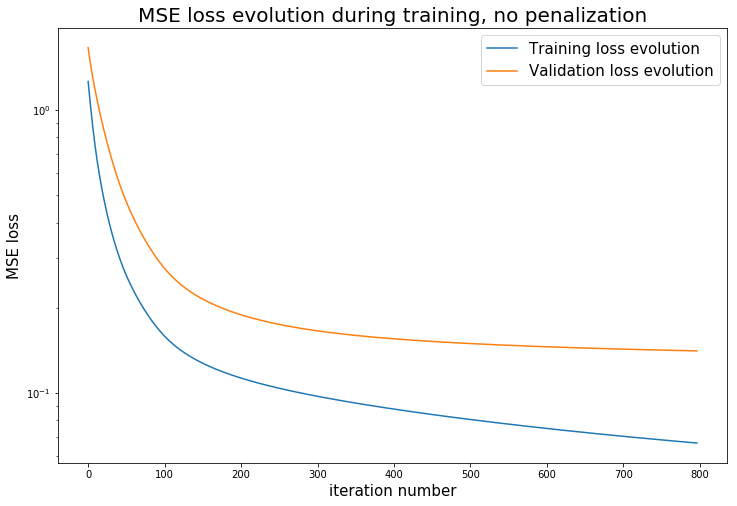

In [69]:
# log reg without regularization
logistic_regressor = LogisticRegressor(X, Y)
logistic_regressor.fit(max_iterations=1000, initial_step=1e-1, step_decay=False)
print(logistic_regressor.accuracy_on_validation())
logistic_regressor.plot_loss_history()

iteration number: 1	 training loss: 2.7943	 validation loss: 2.9077
iteration number: 2	 training loss: 2.5855	 validation loss: 2.6952
iteration number: 3	 training loss: 2.4155	 validation loss: 2.5219
iteration number: 4	 training loss: 2.2720	 validation loss: 2.3745
iteration number: 5	 training loss: 2.1475	 validation loss: 2.2451
iteration number: 6	 training loss: 2.0372	 validation loss: 2.1291
iteration number: 7	 training loss: 1.9379	 validation loss: 2.0238
iteration number: 8	 training loss: 1.8474	 validation loss: 1.9271
iteration number: 9	 training loss: 1.7642	 validation loss: 1.8378
iteration number: 10	 training loss: 1.6871	 validation loss: 1.7549
iteration number: 11	 training loss: 1.6154	 validation loss: 1.6776
iteration number: 12	 training loss: 1.5484	 validation loss: 1.6053
iteration number: 13	 training loss: 1.4857	 validation loss: 1.5375
iteration number: 14	 training loss: 1.4267	 validation loss: 1.4738
iteration number: 15	 training loss: 1.3712

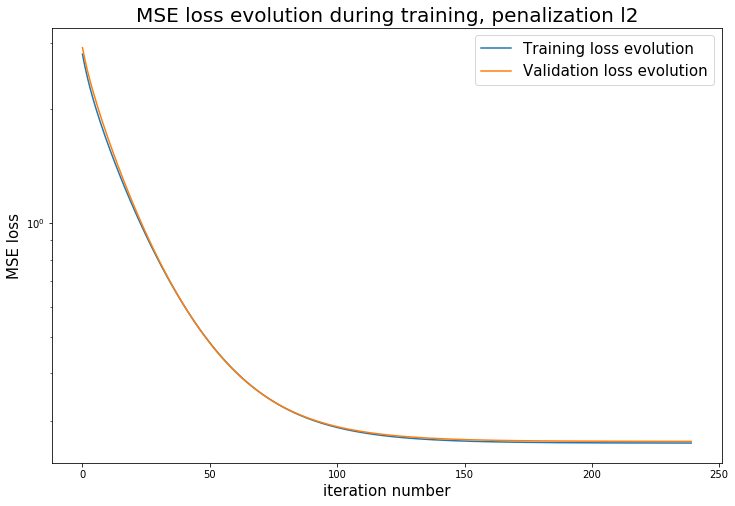

In [16]:
# log reg with l2 regularization
logistic_regressor = LogisticRegressor(X, Y, penalization='l2')
logistic_regressor.fit(max_iterations=1000, gamma=1e-1, initial_step=1e-1, step_decay=False)
print(logistic_regressor.accuracy_on_validation())
logistic_regressor.plot_loss_history()

iteration number: 1	 training loss: 4.2530	 validation loss: 4.4648
iteration number: 2	 training loss: 4.1050	 validation loss: 4.3071
iteration number: 3	 training loss: 3.9598	 validation loss: 4.1513
iteration number: 4	 training loss: 3.8174	 validation loss: 3.9977
iteration number: 5	 training loss: 3.6777	 validation loss: 3.8469
iteration number: 6	 training loss: 3.5407	 validation loss: 3.6991
iteration number: 7	 training loss: 3.4062	 validation loss: 3.5546
iteration number: 8	 training loss: 3.2746	 validation loss: 3.4137
iteration number: 9	 training loss: 3.1462	 validation loss: 3.2766
iteration number: 10	 training loss: 3.0214	 validation loss: 3.1435
iteration number: 11	 training loss: 2.9004	 validation loss: 3.0146
iteration number: 12	 training loss: 2.7832	 validation loss: 2.8901
iteration number: 13	 training loss: 2.6698	 validation loss: 2.7702
iteration number: 14	 training loss: 2.5602	 validation loss: 2.6549
iteration number: 15	 training loss: 2.4542

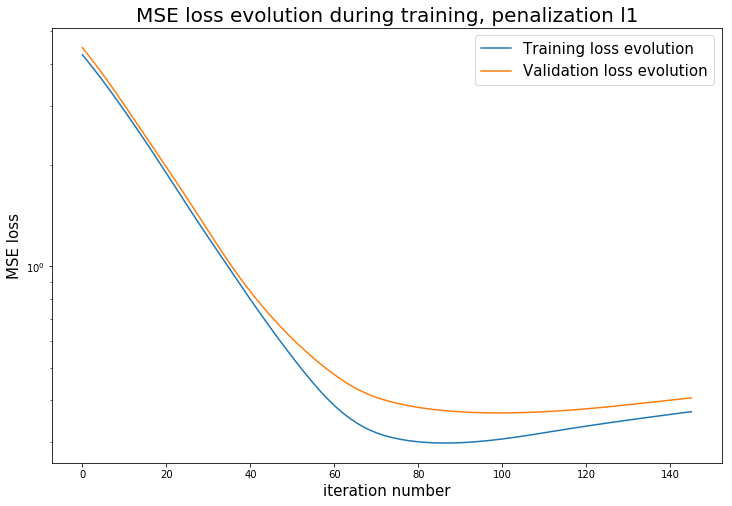

In [71]:
# log reg with l1 regularization
logistic_regressor = LogisticRegressor(X, Y, penalization='l1')
logistic_regressor.fit(max_iterations=1000, gamma=1e-4, initial_step=1e-2, step_decay=True)
print(logistic_regressor.accuracy_on_validation())
logistic_regressor.plot_loss_history()

## Questions:
#### - Did you succeed to reach an accuracy of at least 95% on the validation dataset? If not, what could be the reason?
<span style="color:green">
If you haven't managed, apart from an implementation mistake with the gradients and the penalizations, the reason probably lies in your normalization strategy.
One strategy that works well here is to center your columns data and give them a $1$ standard deviation to control the weights' derivatives of features on large scales.<br/>
Adviced transformation: $X' = \frac{X - \mu}{\sigma}$ <br/>
$X'$ your transformed column data, X former column, $\mu$ column mean, $\sigma$ column standard deviation 
</span>
#### - Why do we need a different loss function for a classification problem (why not MSE again?)
<span style="color:green">
With MSE the final function to minimize wouldn't be convex while it actually is convex with negative loglikelihood loss. It thus far more suited to gradient descent optimization.</span>
#### - Why is the normalization particulary relevant in this case? Compare the performances with and without it. Comment. 
<span style="color:green">
As previously mentioned, there are many features initially on different scales. Features on greater scales may lead to big derivatives and uncontrolled traning due to the same learning rate being applied in all directions of the gradients.
</span>